Диспенсер для моющего средства
Shiny Kitchen 18895524

In [1]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import copy
from copy import deepcopy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


------------

In [12]:
data = pd.read_csv('/content/18895524.csv', sep=';')

In [13]:
data

,Дата,Продажи,Остаток,Цена,Со скидкой и промо,Скидка,Цена со скидкой,Промокод,СПП,Цена с СПП,Сумма продаж,Комментариев,Рейтинг
0,2022-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-15,3,224.0,2131.0,404.0,81.0,404.0,0.0,0.0,404.0,1212,197.0,5.0
2,2022-06-14,1,227.0,2131.0,404.0,81.0,404.0,0.0,0.0,404.0,404,197.0,5.0
3,2022-06-13,3,228.0,2131.0,404.0,81.0,404.0,0.0,0.0,404.0,1212,197.0,5.0
4,2022-06-12,1,230.0,2131.0,404.0,81.0,404.0,0.0,0.0,404.0,404,196.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Среднее (в день),4 шт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1 562,62 ₽",NaN,NaN
96,Дней с наличием,89 дней,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Среднее при наличии,4 шт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1 572,38 ₽",NaN,NaN
98,Потенциал,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"151 856,00 ₽",NaN,NaN


Данные за период с 15.03.2022 по 15.06.2022 

In [14]:
data = data[1:94]

In [15]:
data.duplicated().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 1 to 93
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Дата                93 non-null     object 
 1   Продажи             93 non-null     object 
 2   Остаток             93 non-null     float64
 3   Цена                93 non-null     float64
 4   Со скидкой и промо  93 non-null     float64
 5   Скидка              93 non-null     float64
 6   Цена со скидкой     93 non-null     float64
 7   Промокод            93 non-null     float64
 8   СПП                 93 non-null     float64
 9   Цена с СПП          93 non-null     float64
 10  Сумма продаж        93 non-null     object 
 11  Комментариев        93 non-null     float64
 12  Рейтинг             93 non-null     float64
dtypes: float64(10), object(3)
memory usage: 9.6+ KB


In [17]:
data['Дата'] = pd.to_datetime(data['Дата'], format='%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
data = data.sort_values(by='Дата')

In [22]:
data = data.set_index('Дата')

In [18]:
data['Продажи'] = data['Продажи'].astype('int')
data['Сумма продаж'] = data['Сумма продаж'].astype('float64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
data = data.drop(['Со скидкой и промо', 'Промокод', 'СПП', 'Цена с СПП'], axis=1)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2022-03-15 to 2022-06-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Продажи          93 non-null     int64  
 1   Остаток          93 non-null     float64
 2   Цена             93 non-null     float64
 3   Скидка           93 non-null     float64
 4   Цена со скидкой  93 non-null     float64
 5   Сумма продаж     93 non-null     float64
 6   Комментариев     93 non-null     float64
 7   Рейтинг          93 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 6.5 KB


In [24]:
data.isna().sum()

Продажи            0
Остаток            0
Цена               0
Скидка             0
Цена со скидкой    0
Сумма продаж       0
Комментариев       0
Рейтинг            0
dtype: int64

In [25]:
data.describe()

,Продажи,Остаток,Цена,Скидка,Цена со скидкой,Сумма продаж,Комментариев,Рейтинг
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.0
mean,3.763441,153.935484,1975.387097,77.602151,440.559140,1562.623656,179.096774,5.0
std,3.549029,100.247824,196.869910,1.973409,50.952122,1427.083648,14.218837,0.0
min,0.000000,0.000000,1729.000000,75.000000,380.000000,0.000000,159.000000,5.0
25%,1.000000,61.000000,1729.000000,76.000000,404.000000,468.000000,166.000000,5.0
50%,3.000000,227.000000,2131.000000,78.000000,414.000000,1212.000000,183.000000,5.0
75%,6.000000,249.000000,2131.000000,78.000000,468.000000,2340.000000,192.000000,5.0
max,14.000000,265.000000,2131.000000,81.000000,532.000000,5796.000000,197.000000,5.0


In [26]:
data

,Продажи,Остаток,Цена,Скидка,Цена со скидкой,Сумма продаж,Комментариев,Рейтинг
Дата,,,,,,,,
2022-03-15,6,61.0,1729.0,76.0,414.0,2484.0,159.0,5.0
2022-03-16,12,49.0,1729.0,76.0,414.0,4968.0,159.0,5.0
2022-03-17,9,40.0,1729.0,76.0,414.0,3726.0,159.0,5.0
2022-03-18,7,33.0,1729.0,76.0,414.0,2898.0,159.0,5.0
2022-03-19,11,22.0,1729.0,76.0,414.0,4554.0,159.0,5.0
...,...,...,...,...,...,...,...,...
2022-06-11,5,231.0,2131.0,81.0,404.0,2020.0,196.0,5.0
2022-06-12,1,230.0,2131.0,81.0,404.0,404.0,196.0,5.0
2022-06-13,3,228.0,2131.0,81.0,404.0,1212.0,197.0,5.0


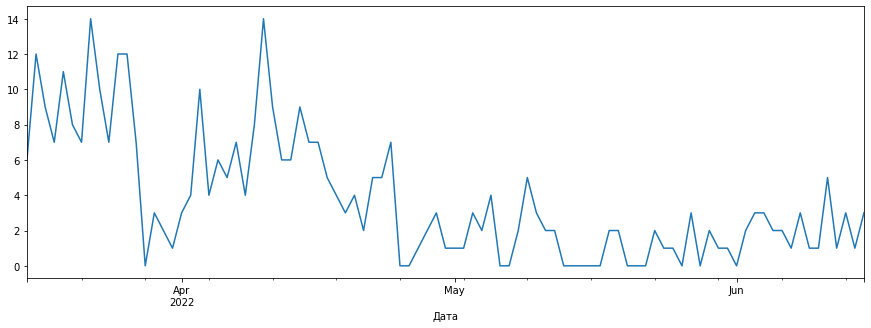

In [109]:
data['Продажи'].plot(figsize=(15,5))

Проведем сезонную декомпозицию.

In [28]:
decomposed = seasonal_decompose(data['Продажи'])

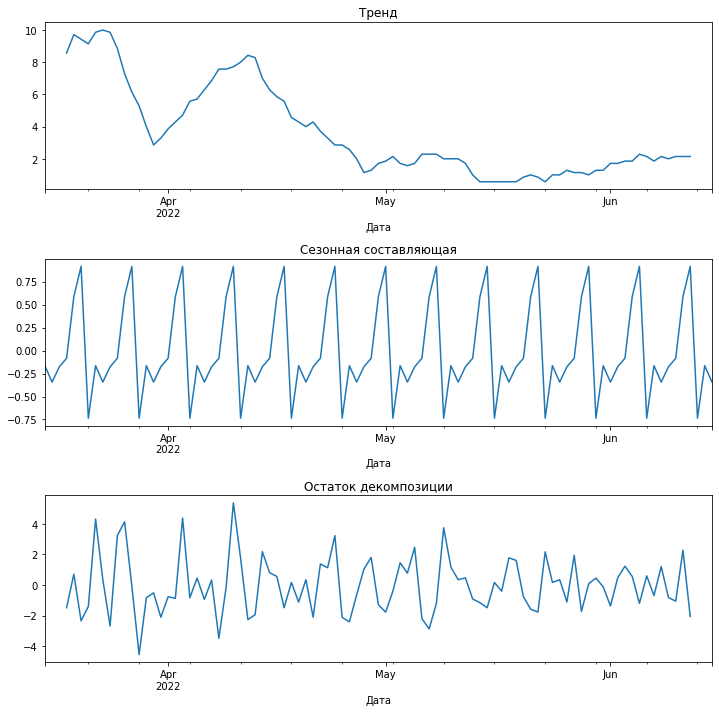

In [29]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонная составляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')

plt.tight_layout()

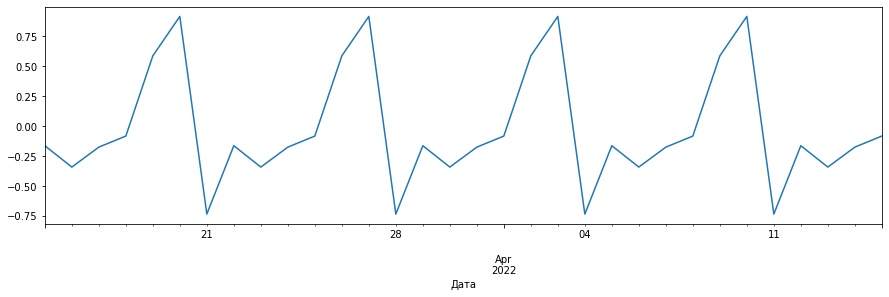

In [32]:
decomposed.seasonal['2022-03-15':'2022-04-15'].plot(figsize=(15, 4)) 

Создадим новые признаки для пострения моделей машинного обучения: календарные (месяц, день, день недели), отстающие значения (до 7 дней), скользящее среднее.

In [33]:
def make_features_new(data, max_lag, rolling_mean_size): # создание признаков

    data_features = deepcopy(data)

    data_features['month'] = data_features.index.month
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_features['lag_' + str(lag)] = data_features['Продажи'].shift(lag)

    data_features['rolling_mean'] = data_features['Продажи'].shift().rolling(rolling_mean_size).mean()
    
    return data_features

In [37]:
data_features = make_features_new(data, 7, 3)

In [38]:
data_features.columns

Index(['Продажи', 'Остаток', 'Цена', 'Скидка', 'Цена со скидкой',
       'Сумма продаж', 'Комментариев', 'Рейтинг', 'month', 'day', 'dayofweek',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'rolling_mean'],
      dtype='object')

In [42]:
data_features[['Продажи','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'rolling_mean']].head(10)

,Продажи,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
Дата,,,,,,,,,
2022-03-22,14,7.0,8.0,11.0,7.0,9.0,12.0,6.0,8.666667
2022-03-23,10,14.0,7.0,8.0,11.0,7.0,9.0,12.0,9.666667
2022-03-24,7,10.0,14.0,7.0,8.0,11.0,7.0,9.0,10.333333
2022-03-25,12,7.0,10.0,14.0,7.0,8.0,11.0,7.0,10.333333
2022-03-26,12,12.0,7.0,10.0,14.0,7.0,8.0,11.0,9.666667
2022-03-27,7,12.0,12.0,7.0,10.0,14.0,7.0,8.0,10.333333
2022-03-28,0,7.0,12.0,12.0,7.0,10.0,14.0,7.0,10.333333
2022-03-29,3,0.0,7.0,12.0,12.0,7.0,10.0,14.0,6.333333
2022-03-30,2,3.0,0.0,7.0,12.0,12.0,7.0,10.0,3.333333


In [41]:
data_features = data_features.dropna()

Обучение

Разделим исходные данные на обучающую, валидационную и тестовую выборки. Делим в отношении 8 : 1 : 1.

In [43]:
features = data_features.drop(['Продажи'], axis=1) # признаки
target = data_features['Продажи'] # целевой признак

In [44]:
features.shape, target.shape

((86, 18), (86,))

In [45]:
# отделим 10% данных для тестовой выборки, данные не перемешиваем
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False) 

In [46]:
# отделим 10% данных для валидационной выборки, данные не перемешиваем
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.111, shuffle=False) 

----------

In [47]:
tscv = TimeSeriesSplit() # cv для cross_val_score и GridSearchCV для временных рядов

In [52]:
def RMSE(target, predictions): # функция для вычисления RMSE
    return (mean_squared_error(target, predictions) ** 0.5)

In [53]:
scoring = make_scorer(RMSE, greater_is_better=False) # scoring=scoring для cross_val_score

In [54]:
df = [] # таблица с результатами
col_data = ['model', 'type_data', 'RMSE']

In [55]:
def predict_result(model, features, target, type_data, name_model): # функция метрики на предсказании

    predictions = model.predict(features) # получим предсказания модели 
    
    result = RMSE(target, predictions) # значение метрики RMSE 
    
#    print("RMSE ", name_model, ":", result)
    
    df.append([name_model, type_data, result])

In [56]:
def plot_test_prediction_result(model, features, target, type_data,  name_model): # тестирование и визуализация

    predictions = model.predict(features) # получим предсказания модели 
    
    result = RMSE(target, predictions) # значение метрики RMSE 
    
    print("RMSE ", name_model, ":", result)
    
    df.append([name_model, type_data, result])   

    pred = pd.DataFrame(data=predictions, index = target.index)
  
    plt.figure(figsize=(12,6))
    plt.plot(target, color='green', label='test')
    plt.plot(pred, color='red', label='predictions')
    plt.title(name_model)
    #plt.xlabel('Date')
    #plt.ylabel('')
    plt.legend()
    plt.show()

--------------

CatBoostRegressor

In [49]:
parameters_CBR = {'loss_function': 'RMSE', # значение по умолчанию
                  'iterations': 1000, # значение по умолчанию
                  'random_state': 12345,
                  'verbose': 500}

model_CBR = CatBoostRegressor(**parameters_CBR)

grid = {'learning_rate': [0.01],
        'depth': [4, 6]}

grid_search_result = model_CBR.grid_search(grid, 
                                           X=features_train, 
                                           y=target_train, cv=tscv)

0:	learn: 5.7626247	test: 1.2771142	best: 1.2771142 (0)	total: 1.07ms	remaining: 1.06s
500:	learn: 0.6624166	test: 0.5364137	best: 0.5364137 (500)	total: 224ms	remaining: 223ms
999:	learn: 0.1566545	test: 0.2878832	best: 0.2878832 (999)	total: 396ms	remaining: 0us

bestTest = 0.2878832312
bestIteration = 999

0:	loss: 0.2878832	best: 0.2878832 (0)	total: 429ms	remaining: 429ms
0:	learn: 5.7644049	test: 1.2782976	best: 1.2782976 (0)	total: 891us	remaining: 891ms
500:	learn: 0.7031132	test: 0.6695340	best: 0.6695340 (500)	total: 325ms	remaining: 324ms
999:	learn: 0.1437175	test: 0.4250677	best: 0.4250677 (999)	total: 658ms	remaining: 0us

bestTest = 0.4250676899
bestIteration = 999

1:	loss: 0.4250677	best: 0.2878832 (0)	total: 1.12s	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 7.9083049	test: 7.5558681	best: 7.5558681 (0)	total: 250us	remaining: 250ms
500:	learn: 1.1891304	test: 2.3207572	best: 2.3207572 (500)	total: 119ms	remaining: 118ms
999:	learn: 0.31

In [50]:
model_CBR.fit(features_train, target_train)

0:	learn: 3.5809862	total: 1.95ms	remaining: 1.95s
500:	learn: 0.4761643	total: 477ms	remaining: 475ms
999:	learn: 0.1344274	total: 909ms	remaining: 0us


In [65]:
 model_CBR.best_score_['learn']['RMSE']

0.13442743148705252

In [57]:
df.append(['CatBoostRegressor', 'train', model_CBR.best_score_['learn']['RMSE']])

-------

XGBRegressor

In [58]:
params = { #'eval_metric': "rmse"
          'max_depth': [6, 8], # 5, 6, 10, 15, 20],
          'learning_rate': [0.3], # 0.1, 0.2, 0.3],
           #'subsample': 0.8,
     #      'colsample_bytree': np.arange(0.4, 1.0, 0.1),
     #      'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100]
}

In [59]:
model_ = XGBRegressor()

In [60]:
model_XGBR = GridSearchCV(model_, params, cv=tscv, scoring=scoring, verbose=1)

In [61]:
model_XGBR.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:47:43] WARNING: /workspace/src/objective/regres

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3], 'max_depth': [6, 8],
                         'n_estimators': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [62]:
model_XGBR.best_params_

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}

In [63]:
df.append(['XGBRegressor', 'train', abs(model_XGBR.best_score_)])

In [64]:
abs(model_XGBR.best_score_)

0.6011141283300322

-----------

LightGBMRegressor

In [66]:
Params = {
    'learning_rate': [0.1, 0.2],
    'num_leaves': [31, 50],
    'n_estimators': [100],
    'objective' : ['regression'],
    'random_state' : [12345] 
    }

In [67]:
model_ = lgb.LGBMRegressor()

In [68]:
model_LGBMR = GridSearchCV(model_, Params, scoring=scoring, cv=tscv, verbose=1)

In [69]:
model_LGBMR.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'num_leaves': [31, 50], 'objective': ['regression'],
                         'random_state': [12345]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [70]:
model_LGBMR.best_params_

{'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 12345}

In [71]:
df.append(['LightGBMRegressor', 'train', abs(model_LGBMR.best_score_)])

In [72]:
abs(model_LGBMR.best_score_)

2.4596102371840254

-----------

RandomForestRegressor

In [73]:
best_modelRFR = None
best_depthRFR = 0
best_est = 0
best_rmseRFR = 10000

for est in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальную глубину дерева

        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) # случайный лес
    
        score = abs(sum(cross_val_score(
            model, features_train, target_train, scoring=scoring, cv=tscv)) / 5)
    
        if score < best_rmseRFR:
            best_modelRFR = model
            best_depthRFR = depth
            best_est = est
            best_rmseRFR = score

            
print("Модель 'Случайный лес', RMSE: ", best_rmseRFR, 
      ", количество деревьев:", best_est, ", глубина дерева:", best_depthRFR)

Модель 'Случайный лес', RMSE:  0.8695590414130313 , количество деревьев: 3 , глубина дерева: 5


In [74]:
best_modelRFR.fit(features_train, target_train)

RandomForestRegressor(max_depth=5, n_estimators=3, random_state=12345)

In [75]:
df.append(['RandomForestRegressor', 'train', best_rmseRFR])

-----------

LinearRegression

In [76]:
modelLinR = LinearRegression() # инициализируем модель LinearRegression

In [77]:
modelLinR.fit(features_train, target_train)

LinearRegression()

In [78]:
predict_result(modelLinR, features_train, target_train, 'train', 'LinearRegression')

----------

In [79]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [80]:
df_result

,model,type_data,RMSE
0,CatBoostRegressor,train,0.134427
1,XGBRegressor,train,0.601114
2,LightGBMRegressor,train,2.459610
3,RandomForestRegressor,train,0.869559
4,LinearRegression,train,0.192773


Тестирование

In [81]:
model = [model_XGBR, 
         model_LGBMR, 
         best_modelRFR,
         modelLinR,
         model_CBR]
name_model = ['XGBRegressor', 
              'LightGBMRegressor',
              'RandomForestRegressor',
              'LinearRegression',
              'CatBoostRegressor']

In [82]:
df.append(['-', '-', '-'])

In [83]:
for _ in range(len(model)):
    predict_result(model[_], features_test, target_test, 'test', name_model[_])

In [84]:
df.append(['-', '-', '-'])

In [85]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [86]:
df_result

,model,type_data,RMSE
0,CatBoostRegressor,train,0.134427
1,XGBRegressor,train,0.601114
2,LightGBMRegressor,train,2.45961
3,RandomForestRegressor,train,0.869559
4,LinearRegression,train,0.192773
5,-,-,-
6,XGBRegressor,test,0.021826
7,LightGBMRegressor,test,1.278717
8,RandomForestRegressor,test,0.111111
9,LinearRegression,test,0.285061


train + valid

Для улучшения качества моделей переобучим их на объединении трейна и валидации.

In [88]:
features_train_valid = pd.concat([features_train, features_valid])

------

In [89]:
model_XGBR.fit(features_train_valid, target_train_valid)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:19] WARNING: /workspace/src/objective/regres

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3], 'max_depth': [6, 8],
                         'n_estimators': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [90]:
df.append(['XGBRegressor', 'train_valid', abs(model_XGBR.best_score_)])

---

In [91]:
model_LGBMR.fit(features_train_valid, target_train_valid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'num_leaves': [31, 50], 'objective': ['regression'],
                         'random_state': [12345]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [92]:
df.append(['LightGBMRegressor', 'train_valid', abs(model_LGBMR.best_score_)])

---------

In [93]:
best_modelRFR.fit(features_train_valid, target_train_valid)

RandomForestRegressor(max_depth=5, n_estimators=3, random_state=12345)

In [94]:
predict_result(
    best_modelRFR, features_train_valid, target_train_valid, 'train_valid', 'RandomForestRegressor')


------

In [95]:
modelLinR.fit(features_train_valid, target_train_valid)

LinearRegression()

In [96]:
predict_result(
    modelLinR, features_train_valid, target_train_valid, 'train_valid', 'LinearRegression')

------

In [97]:
model_CBR.fit(features_train_valid, target_train_valid)

0:	learn: 3.4374942	total: 8.16ms	remaining: 8.15s
500:	learn: 0.4556027	total: 596ms	remaining: 593ms
999:	learn: 0.1314045	total: 1.38s	remaining: 0us


In [98]:
df.append(['model_CBR', 'train_valid', model_CBR.best_score_['learn']['RMSE']])

In [99]:
df.append(['-', '-', '-'])

--------

Финальное тестирование и визуализация

In [100]:
name_model = ['XGBRegressor_train_valid', 
              'LightGBMRegressor_train_valid',
              'RandomForestRegressor_train_valid',
              'LinearRegression_train_valid',
              'CatBoostRegressor_train_valid']

RMSE  XGBRegressor_train_valid : 0.013130324672460959


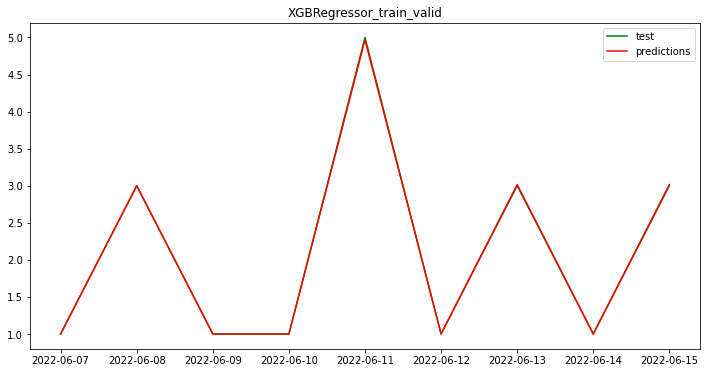

RMSE  LightGBMRegressor_train_valid : 0.9499367221096017


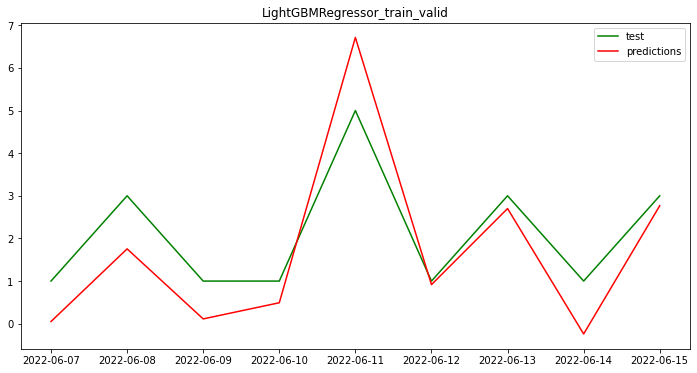

RMSE  RandomForestRegressor_train_valid : 0.0


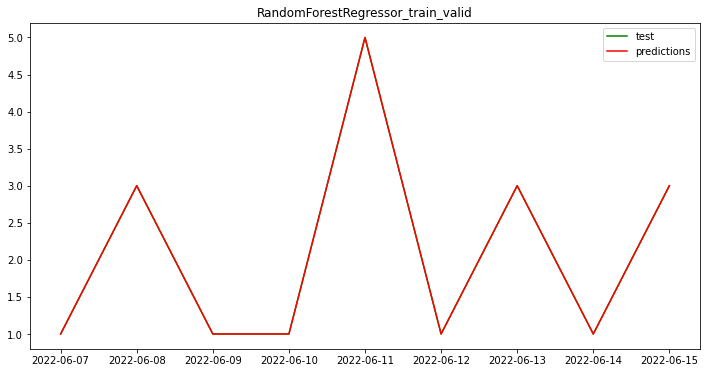

RMSE  LinearRegression_train_valid : 0.12265267513585668


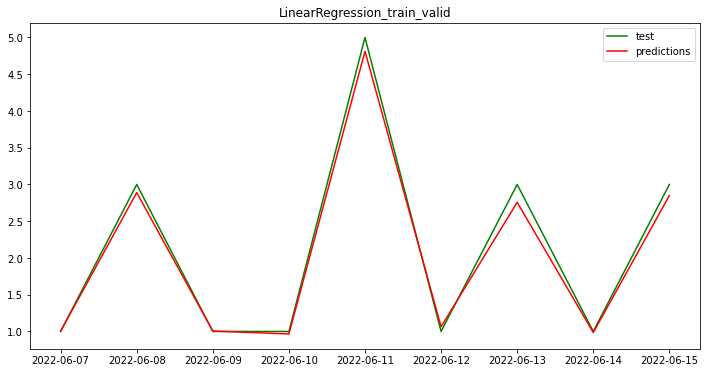

RMSE  CatBoostRegressor_train_valid : 0.24398927561279665


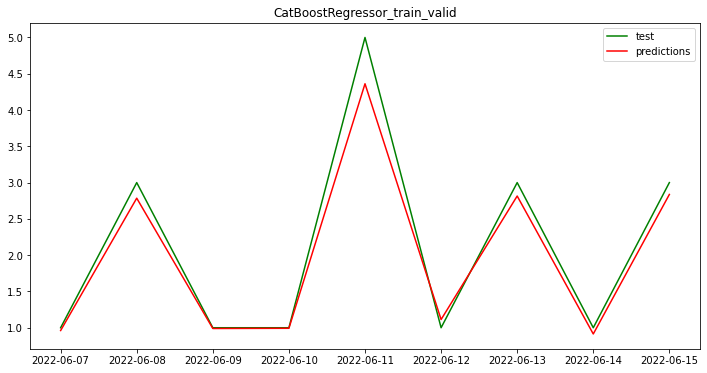

In [101]:
for _ in range(len(model)):
    plot_test_prediction_result(
    model[_], features_test, target_test, 'test', name_model[_])

In [102]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [103]:
df_result

,model,type_data,RMSE
0,CatBoostRegressor,train,0.134427
1,XGBRegressor,train,0.601114
2,LightGBMRegressor,train,2.45961
3,RandomForestRegressor,train,0.869559
4,LinearRegression,train,0.192773
5,-,-,-
6,XGBRegressor,test,0.021826
7,LightGBMRegressor,test,1.278717
8,RandomForestRegressor,test,0.111111
9,LinearRegression,test,0.285061


In [ ]:
model = [model_XGBR, 
         model_LGBMR, 
         best_modelRFR,
         modelLinR,
         model_CBR]

In [104]:
target_test

Дата
2022-06-07    1
2022-06-08    3
2022-06-09    1
2022-06-10    1
2022-06-11    5
2022-06-12    1
2022-06-13    3
2022-06-14    1
2022-06-15    3
Name: Продажи, dtype: int64

In [105]:
best_modelRFR.predict(features_test)

array([1., 3., 1., 1., 5., 1., 3., 1., 3.])

--------------

In [117]:
features_test

,Остаток,Цена,Скидка,Цена со скидкой,Сумма продаж,Комментариев,Рейтинг,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
Дата,,,,,,,,,,,,,,,,,,
2022-06-07,241.0,2131.0,81.0,404.0,404.0,196.0,5.0,6,7,1,2.0,2.0,3.0,3.0,2.0,0.0,1.0,2.333333
2022-06-08,238.0,2131.0,81.0,404.0,1212.0,196.0,5.0,6,8,2,1.0,2.0,2.0,3.0,3.0,2.0,0.0,1.666667
2022-06-09,237.0,2131.0,81.0,404.0,404.0,196.0,5.0,6,9,3,3.0,1.0,2.0,2.0,3.0,3.0,2.0,2.000000
2022-06-10,236.0,2131.0,81.0,404.0,404.0,196.0,5.0,6,10,4,1.0,3.0,1.0,2.0,2.0,3.0,3.0,1.666667
2022-06-11,231.0,2131.0,81.0,404.0,2020.0,196.0,5.0,6,11,5,1.0,1.0,3.0,1.0,2.0,2.0,3.0,1.666667
2022-06-12,230.0,2131.0,81.0,404.0,404.0,196.0,5.0,6,12,6,5.0,1.0,1.0,3.0,1.0,2.0,2.0,2.333333
2022-06-13,228.0,2131.0,81.0,404.0,1212.0,197.0,5.0,6,13,0,1.0,5.0,1.0,1.0,3.0,1.0,2.0,2.333333
2022-06-14,227.0,2131.0,81.0,404.0,404.0,197.0,5.0,6,14,1,3.0,1.0,5.0,1.0,1.0,3.0,1.0,3.000000
2022-06-15,224.0,2131.0,81.0,404.0,1212.0,197.0,5.0,6,15,2,1.0,3.0,1.0,5.0,1.0,1.0,3.0,1.666667


In [ ]:
data_features